# GLM: Poisson Regression Tutorial

In statistics, the Poisson Regression is a generalized linear model form of regression analysis used to model count data and contingency tables. To apply this model, Poisson regression assumes that the response variable Y has a Poisson distribution. \\
In our study case, Covid-19 propagation is a Poisson distribution among population. To apply the Poisson Regression to this study let's first understand how it works on this Tutorial Notebook.

## References

This Notebook is an introduction to the Poisson Regression methods, based on the Notebook: [GLM_Poisson_Regression](https://notebook.community/dolittle007/dolittle007.github.io/notebooks/GLM-poisson-regression)

## Libraries

In [20]:
import sys
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize

# PyMC3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 

# Default settings
sns.set(style="darkgrid", palette="muted")
plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)

## Local Functions

Functions to make the Notebook more convenient.

In [57]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
        
    ax = pm.traceplot(trcs, var_names=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in 
                             pm.summary(trcs,var_names=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, var_names=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

## A Simple Case Study

>This tutorial is based on a simple fictive example: we have recorded the sneezing, drinking alcohol, and taking medication frequencies of an individual during 4000 days. Let's see if they are related. \\
**Assumptions:** \\
>> 1. The subject sneezes N times per day, recorded as `Nsneeze (int)`
1. The subject may or may not drink alcohol during that day, recorded as `Alcohol (boolean)`
1. The subject may or may not take an antihistamine medication during that day, recorded as the negative action `Nomeds (boolean)`
1. The data is aggegated per day, to yield a total count of sneezes on that day, with a boolean flag for alcohol and antihistamine usage, with the big assumption that `Nsneeze` have a direct causal relationship.

## Generate Data

### Creating DataFrame

**Create 4000 days of data: daily counts of sneezes which are poisson distributed w.r.t alcohol consumption and antihistamine usage**

In [21]:
# Defining the Poisson lambda values for each distribution (notice that lambda is equal to E(X))
lambda_noalcohol_meds = 1
lambda_alcohol_meds = 3
lambda_noalcohol_nomeds = 6
lambda_alcohol_nomeds = 36

# Dataset
q = 1000
df = pd.DataFrame({
    'Nsneeze': np.concatenate((np.random.poisson(lambda_noalcohol_meds,q),
                               np.random.poisson(lambda_alcohol_meds,q),
                               np.random.poisson(lambda_noalcohol_nomeds,q),
                               np.random.poisson(lambda_alcohol_nomeds,q))),
    'Alcohol': np.concatenate((np.repeat(False,q),
                               np.repeat(True,q),
                               np.repeat(False,q),
                               np.repeat(True,q))),
    'Nomeds': np.concatenate((np.repeat(False,q),
                               np.repeat(False,q),
                               np.repeat(True,q),
                               np.repeat(True,q)))
})

### DataFrame Visualisation

In [22]:
df

,Nsneeze,Alcohol,Nomeds
0,2,False,False
1,1,False,False
2,1,False,False
3,2,False,False
4,2,False,False
...,...,...,...
3995,38,True,True
3996,31,True,True
3997,30,True,True
3998,34,True,True


### Testing the means

To be certain that our process has created a random Poisson distributed dataset, we can visualise the different means, which are corresponding to the previous defined values. 

In [23]:
df.groupby(['Alcohol','Nomeds']).mean().unstack()

Nsneeze        
Nomeds    False   True 
Alcohol                
False     1.018   5.866
True      2.938  35.889

### Dataset Visualisation

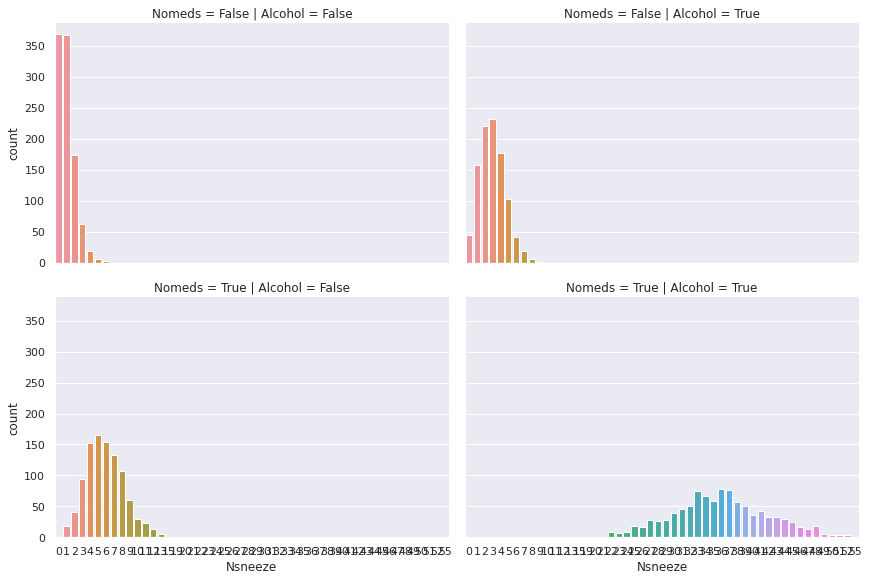

In [24]:
g = sns.factorplot(x='Nsneeze', row='Nomeds', col='Alcohol', data=df,
                   kind='count', size=4, aspect=1.5)

**Observations:** \\
* It seems to be Poisson distributed data as expected.
* The 4 possibilities visually correspond to the defined means.

## Poisson Regression

Our model here is a very simple Poisson Regression, allowing for interaction of terms: 

$$ \theta = exp(\beta X)$$
$$ Y_{sneeze\_count} \approx Poisson(\theta)$$

### Linear model for interaction of terms

In [25]:
formula = 'Nsneeze ~ Alcohol * Nomeds'

### 1. Manual method: Design Matrices

#### Creating Design Matrices

In [29]:
(mx_en, mx_ex) = pt.dmatrices(formula, df, return_type='dataframe', NA_action='raise')

In [30]:
mx_ex

,Intercept,Alcohol[T.True],Nomeds[T.True],Alcohol[T.True]:Nomeds[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
3995,1.0,1.0,1.0,1.0
3996,1.0,1.0,1.0,1.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0


#### Creating Model

In [34]:
with pm.Model() as Poisson_model:

    # Define Priors
    b0 = pm.Normal('b0_Intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_Alcohol[T.True]', mu=0, sd=10)
    b2 = pm.Normal('b2_Nomeds[T.True]', mu=0, sd=10)
    b3 = pm.Normal('b3_Alcohol[T.True]:Nomeds[T.True]', mu=0, sd=10)
    
    # Define linear model and exp link function
    theta = (b0 +
            b1 * mx_ex['Alcohol[T.True]'] +
            b2 * mx_ex['Nomeds[T.True]'] +
            b3 * mx_ex['Alcohol[T.True]:Nomeds[T.True]']) 

    # Define Poisson likelihood 
    y = pm.Poisson('y', mu=np.exp(theta), observed=mx_en['Nsneeze'].values)

#### Sample Model

In [43]:
with Poisson_model:
  Poisson_trace = pm.sample(2000, tune=1000, chains=4)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [b3_Alcohol[T.True]:Nomeds[T.True], b2_Nomeds[T.True], b1_Alcohol[T.True], b0_Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 117 seconds.
The number of effective samples is smaller than 25% for some parameters.


#### View Diagnostics

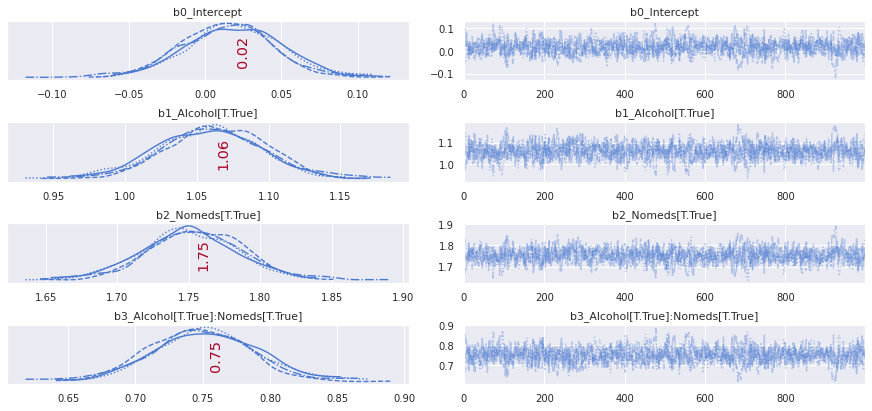

In [58]:
rvs_Poisson = [rv.name for rv in strip_derived_rvs(Poisson_model.unobserved_RVs)]
plot_traces_pymc(Poisson_trace, varnames=rvs_Poisson)

#### Extract Parameters

After making the Poisson Regression manually, the main purpose is to extract the parameters to modelize perfectly, and in this Notebook to find back the theta values defined at the beginning.

In [60]:
pm.summary(Poisson_trace, var_names=rvs_Poisson)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_Intercept,0.017,0.031,-0.039,0.078,0.001,0.001,761.0,826.0,1.01
b1_Alcohol[T.True],1.060,0.036,0.995,1.128,0.001,0.001,785.0,983.0,1.01
b2_Nomeds[T.True],1.752,0.033,1.687,1.814,0.001,0.001,754.0,918.0,1.01
b3_Alcohol[T.True]:Nomeds[T.True],0.751,0.038,0.680,0.823,0.001,0.001,764.0,910.0,1.00


In [62]:
np.exp(pm.summary(Poisson_trace, var_names=rvs_Poisson)[['mean','hdi_3%','hdi_97%']])

,mean,hdi_3%,hdi_97%
b0_Intercept,1.017145,0.961751,1.081123
b1_Alcohol[T.True],2.886371,2.704724,3.089471
b2_Nomeds[T.True],5.766123,5.403247,6.134938
b3_Alcohol[T.True]:Nomeds[T.True],2.119118,1.973878,2.277322


### 2. PyMC3.GLM method

#### Creating Model


In [63]:
with pm.Model() as Poisson_model_glm:
  pm.glm.GLM.from_formula(formula, df, family=pm.glm.families.Poisson())

#### Sample Model

In [64]:
with Poisson_model_glm:
  Poisson_glm_trace = pm.sample(4000, tune=2000)[2000:]

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, Alcohol[T.True]:Nomeds[T.True], Nomeds[T.True], Alcohol[T.True], Intercept]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 216 seconds.


#### View Traces

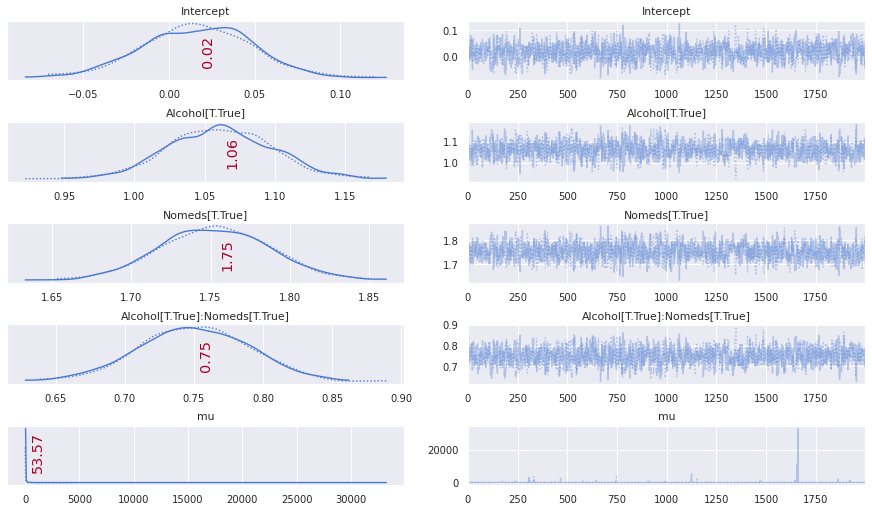

In [66]:
rvs_Poisson_glm = [rv.name for rv in strip_derived_rvs(Poisson_model_glm.unobserved_RVs)]
plot_traces_pymc(Poisson_glm_trace, varnames=rvs_Poisson_glm)

#### Extract Parameters

In [68]:
np.exp(pm.summary(Poisson_glm_trace, var_names=rvs_Poisson_glm)[['mean','hdi_3%','hdi_97%']])

,mean,hdi_3%,hdi_97%
Intercept,1.016129e+00,0.958870,1.078963e+00
Alcohol[T.True],2.889259e+00,2.696622,3.095657e+00
Nomeds[T.True],5.771892e+00,5.397846,6.134938e+00
Alcohol[T.True]:Nomeds[T.True],2.117000e+00,1.969934,2.281881e+00
mu,1.841431e+23,1.002002,3.963630e+51
